# Flappy Bird mit Reinforcement Learning

**Portfolioabgabe im Modul Reinforcement Learning**

Dieses Notebook dokumentiert die Entwicklung und das Training eines RL-Agenten für das Spiel *Flappy Bird* auf Basis von Deep Q-Learning (DQN). Ziel ist es, zentrale Konzepte des Reinforcement Learning wie Exploration, Reward Shaping, Replay Buffer und Target Network praktisch anzuwenden und verschiedene Modellvarianten miteinander zu vergleichen.

Das Notebook ist wie folgt aufgebaut:

1. **Importe und Umgebung**  
   Vorbereitung der benötigten Bibliotheken und Initialisierung der Spielumgebung.

2. **Baseline-Agent**  
   Erste Durchläufe mit einem zufälligen Agenten zur Orientierung.

3. **Zustandsverarbeitung und Modellarchitektur**  
   Extraktion und Vektorisierung des Game States sowie Aufbau des DQN-Modells.

4. **Replay Buffer und Trainingslogik**  
   Implementierung der Speicherstruktur und des Trainingsloops mit ε-greedy Strategie.

5. **Modellvarianten und Training**  
   Durchführung mehrerer Trainingsdurchläufe mit DQN, Target Network und Double DQN.

6. **Visualisierung und Reflexion**  
   Darstellung und Bewertung der Trainingsergebnisse sowie kritische Einordnung.

Weitere Ergebnisse und Analysen sind im zugehörigen Projektbericht dokumentiert.


Import aller notwendigen Bibliotheken

In [1]:
import pygame
import numpy as np
import gym
import time
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from ple.games.flappybird import FlappyBird
from ple import PLE
from collections import deque

/Users/I536606/Library/CloudStorage/OneDrive-SAPSE/Python Projects/RL_2025/venv/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.6.1 (SDL 2.28.4, Python 3.13.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom


### Initialisierung der RL-Umgebung

Die Umgebung basiert auf dem Spiel Flappy Bird und wurde mithilfe der PyGame Learning Environment (PLE) initialisiert. Die `env`-Instanz stellt die Interaktionsschnittstelle für den RL-Agenten dar. Über `getActionSet()` werden die verfügbaren Aktionen des Spiels (z. B. „flap“ oder „nichts tun“) ermittelt.


In [2]:
game = FlappyBird()
env = PLE(game, fps=30, display_screen=True)

env.init()

actions = env.getActionSet()
print("Action space:", actions)


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Action space: [119, None]


### Erste Tests mit einem Random Agent

Zur Überprüfung der Umgebung und der Aktionsausführung wurde zunächst ein einfacher Random Agent implementiert. Der Agent wählt in jeder Frame zufällig zwischen den verfügbaren Aktionen. Ziel dieser Phase war es, den Ablauf des Spiels, das Reward-System sowie die Reset-Logik zu verstehen. Wie erwartet zeigt sich, dass der Agent in jeder Episode sofort stirbt, was sich in konstant niedrigen Total Rewards von -5.0 widerspiegelt. 

In [3]:
env.reset_game()
state = env.getGameState()
print(state)

actions = env.getActionSet()

n_episodes = 5
max_frames = 200

for episode in range(n_episodes):
    print(f"Episode {episode+1}")
    env.reset_game()
    total_reward = 0
    
    for frame in range(max_frames):
        if env.game_over():
            break

        action = random.choice(actions)  # zufällige Aktion
        reward = env.act(action)         # Aktion ausführen
        total_reward += reward
        
        time.sleep(0.02)  

    print(f"Total reward in episode {episode+1}: {total_reward}")


{'player_y': 256, 'player_vel': 0, 'next_pipe_dist_to_player': 309.0, 'next_pipe_top_y': np.int64(53), 'next_pipe_bottom_y': np.int64(153), 'next_next_pipe_dist_to_player': 453.0, 'next_next_pipe_top_y': np.int64(153), 'next_next_pipe_bottom_y': np.int64(253)}
Episode 1
Total reward in episode 1: -5.0
Episode 2
Total reward in episode 2: -5.0
Episode 3
Total reward in episode 3: -5.0
Episode 4
Total reward in episode 4: -5.0
Episode 5
Total reward in episode 5: -5.0


### Extraktion und Vektorisierung des Zustands

Um den Zustand der Umgebung als Input für das neuronale Netz verarbeiten zu können, wurde das über `getGameState()` gelieferte Dictionary in einen NumPy-Vektor umgewandelt. Dadurch liegt der Zustand in numerischer Form vor, sodass er vom DQN-Modell genutzt werden kann. Der Vektor enthält unter anderem Informationen zur Position des Spielers, zur Geschwindigkeit und zur Distanz zur nächsten Röhre.


In [4]:
state_dict = env.getGameState()
state_vector = np.array(list(state_dict.values()), dtype=np.float32)

print("State vector:", state_vector)
print("Shape:", state_vector.shape)


State vector: [ 21.  -8.  61. 145. 245. 205. 153. 253.]
Shape: (8,)


### Definition des Deep Q-Networks (DQN)

Das neuronale Netz wurde als Deep Q-Network (DQN) implementiert und besteht aus zwei versteckten Schichten mit jeweils 128 Neuronen. Als Input dient der zuvor extrahierte Zustandsvektor mit acht Dimensionen. Das Modell gibt für jede mögliche Aktion (flap / nichts tun) einen Q-Wert aus. 

In [5]:
class DQN(nn.Module):
    def __init__(self, input_dim=8, output_dim=2):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)


### Erste Vorhersage mit dem DQN-Modell

Zur Überprüfung der Architektur wurde das zuvor definierte DQN-Modell mit einem Beispielzustand getestet. Dabei wurde der Zustandsvektor in einen Tensor umgewandelt und als Input verwendet. Das Modell gibt zwei Q-Werte aus, jeweils einen für die mögliche Aktion „flap“ bzw. „nichts tun“. Diese Werte sind zu diesem Zeitpunkt noch zufällig initialisiert, dienen aber als funktionaler Test des Forward-Passes.

In [6]:
model = DQN()

state_tensor = torch.tensor(state_vector, dtype=torch.float32).unsqueeze(0)

# Vorhersage der Q-Werte
q_values = model(state_tensor)

print("Q-Werte für Aktionen:", q_values)
print("Aktion mit höchstem Q-Wert:", torch.argmax(q_values).item())


Q-Werte für Aktionen: tensor([[14.6894, -6.6553]], grad_fn=<AddmmBackward0>)
Aktion mit höchstem Q-Wert: 0


### Implementierung des Replay Buffers

Zur Stabilisierung des Lernprozesses wurde ein Replay Buffer implementiert. Dieser speichert Transitionen in Form von (state, action, reward, next_state, done) und erlaubt zufälliges Sampling während des Trainings. Die Entkopplung der Trainingsdaten vom zeitlichen Verlauf des Spiels verringert Korrelationen und entspricht der empfohlenen Vorgehensweise im Deep Q-Learning (vgl. Vorlesung).


In [7]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.buffer)


### Test des Replay Buffers mit Beispielübergang

Um die Funktionsfähigkeit des Replay Buffers zu überprüfen, wurde ein Beispielübergang manuell gespeichert und anschließend per Sampling wieder ausgelesen. Damit konnte sichergestellt werden, dass das Datenformat korrekt ist und der Buffer wie vorgesehen arbeitet. Dieser Zwischenschritt erleichtert die spätere Integration in den Trainingsprozess.

In [8]:
# Replay Buffer anlegen
buffer = ReplayBuffer()

buffer.push(
    state=np.random.randn(8),              # Zustand
    action=1,                              # flap
    reward=1.0,                            # Belohnung
    next_state=np.random.randn(8),         # nächster Zustand
    done=False                             # Episode vorbei?
)

# Test: Sample ziehen
sample = buffer.sample(1)
print("Sample:", sample)


Sample: (array([[-0.11657359,  0.83166373, -0.1660288 ,  0.88179895,  1.51572136,
         0.37419566, -0.56441969,  1.04254988]]), array([1]), array([1.]), array([[-0.13146833, -0.54412219, -1.05323987,  0.10730497, -1.07465542,
         1.13050684,  0.98230289, -0.80386979]]), array([False]))


### Trainingsfunktion für den DQN-Agenten

Die Funktion `train_dqn` implementiert das eigentliche Lernverfahren auf Basis des Bellman-Updates. Für ein zufällig gesampeltes Mini-Batch aus dem Replay Buffer wird jeweils die aktuelle Q-Schätzung `Q(s, a)` mit dem Zielwert `r + γ · max Q(s′, a′)` verglichen. Die Differenz wird mittels Mean Squared Error minimiert. Um instabile Updates zu vermeiden, wird das Target innerhalb eines `torch.no_grad()`-Blocks berechnet. Diese Methode entspricht dem klassischen DQN-Ansatz nach Mnih et al. (2013) (https://doi.org/10.48550/arXiv.1312.5602)

In [9]:
def train_dqn(model, buffer, optimizer, batch_size=32, gamma=0.99):
    if len(buffer) < batch_size:
        return  

    states, actions, rewards, next_states, dones = buffer.sample(batch_size)

    # In Tensoren umwandeln
    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
    rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

    # Q(s, a)
    q_values = model(states).gather(1, actions)

    with torch.no_grad():
        max_next_q = model(next_states).max(1)[0].unsqueeze(1)
        target_q = rewards + (gamma * max_next_q * (1 - dones))  # done = 1 → kein Q-Wert mehr

    loss = F.mse_loss(q_values, target_q)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


### Initialisierung von Modell und Optimierungsverfahren

Vor dem eigentlichen Training wird das DQN-Modell instanziiert und mit dem Adam-Optimierer konfiguriert. Die Lernrate wurde auf 0.001 gesetzt, was sich in vielen Deep-RL-Szenarien als praktikabler Startwert erwiesen hat. Die Kombination aus Modell und Optimierer bildet die technische Grundlage für den Lernprozess.

In [10]:
model = DQN()
optimizer = optim.Adam(model.parameters(), lr=0.001)


### Testweises Ausführen eines Trainingsschritts

Zur Überprüfung der Trainingsfunktion wurde ein erster Trainingsschritt ausgeführt. Da der Replay Buffer zu diesem Zeitpunkt noch weniger als ein Mini-Batch enthält, gibt die Funktion erwartungsgemäß `None` zurück. Dieser Zwischenschritt dient der technischen Validierung der Trainingslogik vor dem vollständigen Loop.

In [11]:
loss = train_dqn(model, buffer, optimizer)
print("Trainingsloss:", loss)


Trainingsloss: None


### Erster Trainingsloop mit ε-greedy Exploration

Im nächsten Schritt wurde ein vollständiger Trainingsloop implementiert. Der Agent interagiert über mehrere Episoden hinweg mit der Umgebung, speichert Übergänge im Replay Buffer und wird schrittweise mithilfe der train_dqn-Funktion optimiert. Die Aktionswahl erfolgt dabei über eine ε-greedy Strategie, die schrittweise von Exploration zu Exploitation übergeht. Wie erwartet zeigt der Agent in dieser frühen Phase noch kein verbessertes Verhalten, denn alle Episoden enden mit einem Total Reward von -5, was auf sofortiges Scheitern hinweist. Diese Beobachtung verdeutlicht, dass weiterführende Techniken wie Reward Shaping oder Target Networks verwendet werden sollten.


In [12]:
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay = 500  # je kleiner, desto schneller wird ausexploriert

num_episodes = 200
batch_size = 32
gamma = 0.99

rewards = []
epsilon = epsilon_start

for episode in range(num_episodes):
    env.reset_game()
    state = np.array(list(env.getGameState().values()), dtype=np.float32)
    total_reward = 0

    while not env.game_over():
        # ε-greedy Action Selection
        if np.random.rand() < epsilon:
            action = random.choice(actions)
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            q_values = model(state_tensor)
            action_index = torch.argmax(q_values).item()
            action = actions[action_index]  # Mapping zurück auf Action-Set [119, None]

        reward = env.act(action)
        next_state = np.array(list(env.getGameState().values()), dtype=np.float32)
        done = env.game_over()

        buffer.push(state, actions.index(action), reward, next_state, done)

        loss = train_dqn(model, buffer, optimizer, batch_size, gamma)

        state = next_state
        total_reward += reward

    # ε reduzieren
    epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-episode / epsilon_decay)

    rewards.append(total_reward)
    print(f"Episode {episode+1}: Total Reward = {total_reward}, Epsilon = {epsilon:.3f}")


Episode 1: Total Reward = -5.0, Epsilon = 1.000
Episode 2: Total Reward = -5.0, Epsilon = 0.998
Episode 3: Total Reward = -5.0, Epsilon = 0.996
Episode 4: Total Reward = -5.0, Epsilon = 0.995
Episode 5: Total Reward = -5.0, Epsilon = 0.993
Episode 6: Total Reward = -5.0, Epsilon = 0.991
Episode 7: Total Reward = -5.0, Epsilon = 0.989
Episode 8: Total Reward = -5.0, Epsilon = 0.987
Episode 9: Total Reward = -5.0, Epsilon = 0.986
Episode 10: Total Reward = -5.0, Epsilon = 0.984
Episode 11: Total Reward = -4.0, Epsilon = 0.982
Episode 12: Total Reward = -5.0, Epsilon = 0.980
Episode 13: Total Reward = -5.0, Epsilon = 0.979
Episode 14: Total Reward = -5.0, Epsilon = 0.977
Episode 15: Total Reward = -5.0, Epsilon = 0.975
Episode 16: Total Reward = -5.0, Epsilon = 0.973
Episode 17: Total Reward = -5.0, Epsilon = 0.972
Episode 18: Total Reward = -5.0, Epsilon = 0.970
Episode 19: Total Reward = -5.0, Epsilon = 0.968
Episode 20: Total Reward = -5.0, Epsilon = 0.966
Episode 21: Total Reward = -5

### Visualisierung des Trainingsverlaufs

Zur besseren Einordnung des Lernfortschritts wurde der Total Reward über alle Episoden hinweg visualisiert. Die Lernkurve zeigt in dieser frühen Phase noch keine Verbesserung, was den Bedarf nach weiteren Optimierungsmaßnahmen unterstreicht. Die Visualisierung dient gleichzeitig als Referenzpunkt für spätere Vergleiche mit verfeinerten Agentenvarianten.

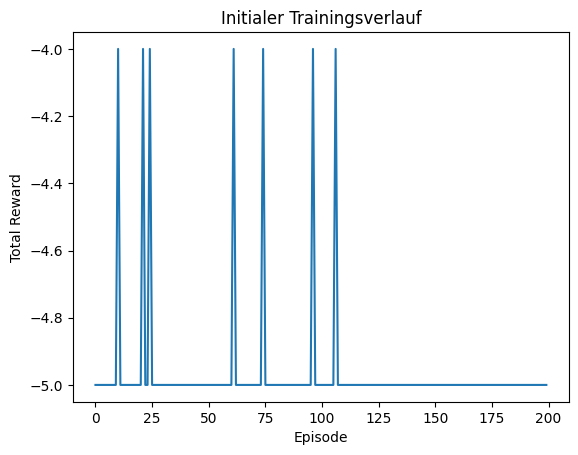

In [13]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Initialer Trainingsverlauf")
plt.show()


### Vorbefüllen des Replay Buffers (Warm-up Phase)

Da das Training zu Beginn keine Lernfortschritte zeigte, wurde der Replay Buffer vor dem eigentlichen Lernprozess mit zufälligen Erfahrungen befüllt. In dieser Warm-up Phase sammelt der Agent über 1000 zufällige Schritte Zustände, Aktionen, Rewards und Folgezustände. Dies entspricht einem in der Literatur häufig eingesetzten Vorgehen, um das Lernen zu stabilisieren und zu verhindern, dass der Agent zu früh mit stark korrelierten Daten trainiert.

In [14]:
warmup_steps = 1000
for _ in range(warmup_steps):
    env.reset_game()
    state = np.array(list(env.getGameState().values()), dtype=np.float32)
    while not env.game_over():
        action = random.choice(actions)
        reward = env.act(action)
        next_state = np.array(list(env.getGameState().values()), dtype=np.float32)
        done = env.game_over()
        buffer.push(state, actions.index(action), reward, next_state, done)
        state = next_state


### Trainingsloop mit Replay Buffer und Reward Shaping

Auf Basis des vorbefüllten Replay Buffers wurde der eigentliche Trainingsloop umgesetzt. Der Agent trainiert über 200 Episoden hinweg mithilfe einer ε-greedy Strategie, die Exploration und Exploitation balanciert. Um dem Agenten ein kontinuierlicheres Belohnungssignal zu geben, wurde Reward Shaping eingeführt. Für jeden überlebten Frame erhält der Agent einen kleinen positiven Zusatzreward. Erste Trainingserfolge wurden hier sichtbar, da der Total Reward nach wenigen Episoden ansteigt und sich gegen Ende des Trainings auf konstant positiven Werten stabilisiert. Damit ist die Lernfähigkeit des Agenten unter realistischen Bedingungen nachgewiesen.

In [15]:
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay = 500

num_episodes = 200
batch_size = 32
gamma = 0.99
learning_rate = 0.0005

rewards = []
epsilon = epsilon_start
model = DQN()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for episode in range(num_episodes):
    env.reset_game()
    state = np.array(list(env.getGameState().values()), dtype=np.float32)
    total_reward = 0

    while not env.game_over():
        # ε-greedy Action Selection
        if np.random.rand() < epsilon:
            action = random.choice(actions)
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            q_values = model(state_tensor)
            action_index = torch.argmax(q_values).item()
            action = actions[action_index]

        # Reward shaping: Überleben leicht belohnen
        reward = env.act(action)
        reward = reward + 0.1  

        next_state = np.array(list(env.getGameState().values()), dtype=np.float32)
        done = env.game_over()

        # Übergang speichern
        buffer.push(state, actions.index(action), reward, next_state, done)

        # DQN-Training
        loss = train_dqn(model, buffer, optimizer, batch_size, gamma)

        state = next_state
        total_reward += reward

    # ε reduzieren
    epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-episode / epsilon_decay)

    rewards.append(total_reward)
    print(f"Episode {episode+1}: Total Reward = {total_reward:.2f}, Epsilon = {epsilon:.3f}")


Episode 1: Total Reward = 2.60, Epsilon = 1.000
Episode 2: Total Reward = 0.90, Epsilon = 0.998
Episode 3: Total Reward = -0.40, Epsilon = 0.996
Episode 4: Total Reward = 0.20, Epsilon = 0.995
Episode 5: Total Reward = -1.00, Epsilon = 0.993
Episode 6: Total Reward = 1.20, Epsilon = 0.991
Episode 7: Total Reward = -1.20, Epsilon = 0.989
Episode 8: Total Reward = 1.20, Epsilon = 0.987
Episode 9: Total Reward = -0.40, Epsilon = 0.986
Episode 10: Total Reward = -0.10, Epsilon = 0.984
Episode 11: Total Reward = 0.40, Epsilon = 0.982
Episode 12: Total Reward = 1.20, Epsilon = 0.980
Episode 13: Total Reward = -0.50, Epsilon = 0.979
Episode 14: Total Reward = 0.80, Epsilon = 0.977
Episode 15: Total Reward = -0.40, Epsilon = 0.975
Episode 16: Total Reward = 0.10, Epsilon = 0.973
Episode 17: Total Reward = 1.10, Epsilon = 0.972
Episode 18: Total Reward = -0.40, Epsilon = 0.970
Episode 19: Total Reward = 0.10, Epsilon = 0.968
Episode 20: Total Reward = 1.20, Epsilon = 0.966
Episode 21: Total Rew

### Visualisierung des Trainingsverlaufs mit optimiertem DQN

Die Lernkurve zeigt einen insgesamt positiven Trend, auch wenn der Fortschritt weiterhin von deutlichen Schwankungen geprägt ist. Der Agent erzielt in vielen Episoden Total Rewards über null, vereinzelt auch Höchstwerte bis sechs, was auf vereinzelte erfolgreiche Durchläufe hindeutet. Trotzdem bleibt das Verhalten instabil, und längere Phasen mit stagnierenden oder negativen Rewards sind weiterhin sichtbar. Insgesamt deutet der Verlauf darauf hin, dass die Kombination aus Replay Buffer, Reward Shaping und ε-greedy Exploration ein grundlegendes Lernen ermöglicht, aber noch keine robuste Strategie hervorgebracht wurde. Eine Verlängerung des Trainings oder feinere Justierungen an Hyperparametern könnten helfen, das Lernverhalten weiter zu stabilisieren.

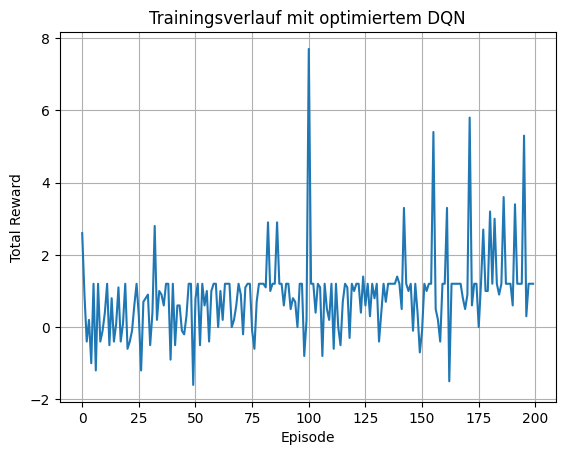

In [16]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Trainingsverlauf mit optimiertem DQN")
plt.grid(True)
plt.show()

### Einführung eines Target Networks zur Stabilisierung des Lernprozesses

Um instabile Updates beim Training zu vermeiden, wurde ein zusätzliches Target Network eingeführt. Es wird initial als Kopie des Hauptnetzwerks (`model`) angelegt und während des Trainings regelmäßig aktualisiert. Bei der Berechnung des TD-Targets wird dieses Netzwerk verwendet, um die Q-Werte für den nächsten Zustand zu schätzen. Dadurch wird das Training robuster gegenüber kurzfristigen Schwankungen in den Q-Werten.

In [17]:
# 🎯 Target Network initialisieren (stabilere Q-Ziele)
target_model = DQN()
target_model.load_state_dict(model.state_dict())
target_model.eval()

DQN(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=2, bias=True)
)

### Trainingsfunktion mit Target Network (klassisches DQN)

Diese Version der `train_dqn`-Funktion nutzt ein separates Target Network zur Berechnung des Zielwerts. Der aktuelle Q-Wert `Q(s, a)` wird mit dem Zielwert `r + γ · max_a′ Q_target(s′, a′)` verglichen, wobei `Q_target` aus einem eingefrorenen Netzwerk stammt, das nur periodisch aktualisiert wird. Durch diese Trennung wird das sogenannte "Moving Target"-Problem im klassischen Q-Learning reduziert. Diese Anpassung folgt dem Deep Q-Network-Ansatz nach Mnih et al. (2015) und ist eine etablierte Technik zur Stabilisierung des Lernprozesses.

In [18]:
def train_dqn(model, target_model, buffer, optimizer, batch_size=32, gamma=0.99):
    if len(buffer) < batch_size:
        return

    states, actions, rewards, next_states, dones = buffer.sample(batch_size)

    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
    rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

    # Q(s, a)
    q_values = model(states).gather(1, actions)

    # 🎯 Target: r + γ · max_a′ Q_target(s′, a′)
    with torch.no_grad():
        max_next_q = target_model(next_states).max(1)[0].unsqueeze(1)
        target_q = rewards + (gamma * max_next_q * (1 - dones))

    loss = F.mse_loss(q_values, target_q)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


### Trainingsloop mit Target Network

In dieser Version des Trainingsloops wurde das zuvor initialisierte Target Network eingebunden. Das Hauptnetzwerk (`model`) wird weiterhin bei jedem Schritt trainiert, während das Target Network (`target_model`) alle 10 Episoden aktualisiert wird. Diese Trennung stabilisiert das Lernen, da das Target für das TD-Update nicht aus einem gleichzeitig aktualisierten Netzwerk stammt. Zusätzlich bleibt die ε-greedy Strategie aktiv und Reward Shaping sorgt weiterhin für ein differenzierteres Feedback. Die getroffenen Entscheidungen entsprechen bewährten Praktiken im Deep Q-Learning.

In [19]:
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay = 500

num_episodes = 200
batch_size = 32
gamma = 0.99
learning_rate = 0.0005

rewards = []
epsilon = epsilon_start
model = DQN()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for episode in range(num_episodes):
    env.reset_game()
    state = np.array(list(env.getGameState().values()), dtype=np.float32)
    total_reward = 0

    while not env.game_over():
        # ε-greedy Action Selection
        if np.random.rand() < epsilon:
            action = random.choice(actions)
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            q_values = model(state_tensor)
            action_index = torch.argmax(q_values).item()
            action = actions[action_index]

        # Reward shaping
        reward = env.act(action)
        reward = reward + 0.1 

        next_state = np.array(list(env.getGameState().values()), dtype=np.float32)
        done = env.game_over()

        # Übergang speichern
        buffer.push(state, actions.index(action), reward, next_state, done)

        # DQN-Training
        loss = train_dqn(model, target_model, buffer, optimizer, batch_size, gamma)  

        state = next_state
        total_reward += reward

    # ε reduzieren
    epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-episode / epsilon_decay)

    rewards.append(total_reward)
    if episode % 10 == 0:
        target_model.load_state_dict(model.state_dict())
    print(f"Episode {episode+1}: Total Reward = {total_reward:.2f}, Epsilon = {epsilon:.3f}")


Episode 1: Total Reward = 0.10, Epsilon = 1.000
Episode 2: Total Reward = -0.30, Epsilon = 0.998
Episode 3: Total Reward = 0.70, Epsilon = 0.996
Episode 4: Total Reward = 1.20, Epsilon = 0.995
Episode 5: Total Reward = 0.60, Epsilon = 0.993
Episode 6: Total Reward = -0.70, Epsilon = 0.991
Episode 7: Total Reward = 0.80, Epsilon = 0.989
Episode 8: Total Reward = 0.40, Epsilon = 0.987
Episode 9: Total Reward = -0.00, Epsilon = 0.986
Episode 10: Total Reward = 0.10, Epsilon = 0.984
Episode 11: Total Reward = 0.80, Epsilon = 0.982
Episode 12: Total Reward = -0.30, Epsilon = 0.980
Episode 13: Total Reward = -0.00, Epsilon = 0.979
Episode 14: Total Reward = 1.00, Epsilon = 0.977
Episode 15: Total Reward = 1.20, Epsilon = 0.975
Episode 16: Total Reward = 0.20, Epsilon = 0.973
Episode 17: Total Reward = 0.50, Epsilon = 0.972
Episode 18: Total Reward = 0.60, Epsilon = 0.970
Episode 19: Total Reward = 0.60, Epsilon = 0.968
Episode 20: Total Reward = 1.20, Epsilon = 0.966
Episode 21: Total Reward

### Trainingsverlauf mit Target Network

Der Trainingsverlauf zeigt nach Integration eines Target Networks einzelne positive Ausschläge, bleibt insgesamt jedoch durch starke Schwankungen geprägt. In mehreren Episoden erreicht der Agent höhere Total Rewards, was auf erste Fortschritte im Lernprozess hindeutet. Eine konsistente Leistungssteigerung ist allerdings nicht erkennbar. Die Verwendung eines Target Networks stellt eine sinnvolle Ergänzung dar, um instabile Q-Wert-Updates abzumildern, hat im aktuellen Trainingsverlauf jedoch noch nicht zu einer stabilen oder reproduzierbaren Policy geführt.

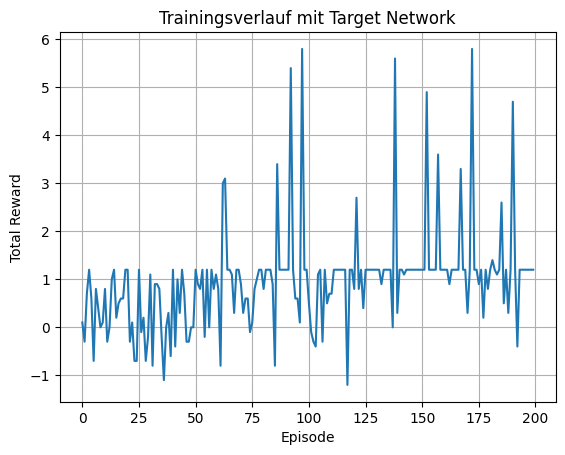

In [20]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Trainingsverlauf mit Target Network")
plt.grid(True)
plt.show()

### Erweiterung auf Double DQN zur Reduktion von Q-Wert-Überschätzungen

In dieser Version der Trainingsfunktion wurde Double DQN implementiert. Dabei wird die nächste Aktion (`argmax Q(s′, a′)`) weiterhin mit dem Online-Netzwerk (`model`) bestimmt, jedoch mit dem Target Network (`target_model`) bewertet. Diese Trennung vermeidet systematische Überschätzungen der Q-Werte, wie sie im klassischen DQN auftreten können. Double DQN basiert auf dem Ansatz von van Hasselt et al. (2016) (https://doi.org/10.48550/arXiv.1509.06461) und stellt eine bewährte Erweiterung zur Steigerung der Lernstabilität und Genauigkeit dar.

In [21]:
def train_dqn(model, target_model, buffer, optimizer, batch_size=32, gamma=0.99):
    if len(buffer) < batch_size:
        return

    states, actions, rewards, next_states, dones = buffer.sample(batch_size)

    states = torch.tensor(states, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
    rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
    next_states = torch.tensor(next_states, dtype=torch.float32)
    dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

    q_values = model(states).gather(1, actions)

    # Double DQN
    with torch.no_grad():
        next_actions = model(next_states).argmax(1).unsqueeze(1)
        next_q_values = target_model(next_states).gather(1, next_actions)
        target_q = rewards + (gamma * next_q_values * (1 - dones))

    loss = F.mse_loss(q_values, target_q)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


### Trainingsloop mit Double DQN

In dieser finalen Version des Trainingsloops wurde Double DQN umgesetzt. Das Online-Netzwerk wählt die jeweils beste Aktion für den nächsten Zustand, während das Target-Netzwerk diese Aktion unabhängig davon bewertet. Zusätzlich wird das Target-Netzwerk alle 10 Episoden mit dem Online-Netzwerk synchronisiert. Ziel dieser Architektur ist es, Q-Wert-Überschätzungen zu vermeiden und die Trainingsstabilität weiter zu erhöhen. Die Kombination aus Replay Buffer, Reward Shaping und ε-greedy Strategie bleibt erhalten, um das Lernen zu unterstützen und Exploration zu gewährleisten.

In [22]:
epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay = 500

num_episodes = 200
batch_size = 32
gamma = 0.99
learning_rate = 0.0005

rewards = []
epsilon = epsilon_start

# Netzwerke & Optimizer
model = DQN()
target_model = DQN()
target_model.load_state_dict(model.state_dict())
target_model.eval()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for episode in range(num_episodes):
    env.reset_game()
    state = np.array(list(env.getGameState().values()), dtype=np.float32)
    total_reward = 0

    while not env.game_over():
        # ε-greedy Action Selection
        if np.random.rand() < epsilon:
            action = random.choice(actions)
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            q_values = model(state_tensor)
            action_index = torch.argmax(q_values).item()
            action = actions[action_index]

        # Reward + shaping
        reward = env.act(action)
        reward = reward + 0.1

        next_state = np.array(list(env.getGameState().values()), dtype=np.float32)
        done = env.game_over()

        buffer.push(state, actions.index(action), reward, next_state, done)

        # Double DQN Trainingsschritt
        loss = train_dqn(model, target_model, buffer, optimizer, batch_size, gamma)

        state = next_state
        total_reward += reward

    # Target-Network aktualisieren
    if episode % 10 == 0:
        target_model.load_state_dict(model.state_dict())

    # ε reduzieren
    epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-episode / epsilon_decay)

    rewards.append(total_reward)
    print(f"Episode {episode+1}: Total Reward = {total_reward:.2f}, Epsilon = {epsilon:.3f}")


Episode 1: Total Reward = -0.40, Epsilon = 1.000
Episode 2: Total Reward = -0.50, Epsilon = 0.998
Episode 3: Total Reward = -0.20, Epsilon = 0.996
Episode 4: Total Reward = 0.40, Epsilon = 0.995
Episode 5: Total Reward = -0.00, Epsilon = 0.993
Episode 6: Total Reward = 1.10, Epsilon = 0.991
Episode 7: Total Reward = 1.00, Epsilon = 0.989
Episode 8: Total Reward = 0.10, Epsilon = 0.987
Episode 9: Total Reward = -0.20, Epsilon = 0.986
Episode 10: Total Reward = 1.20, Epsilon = 0.984
Episode 11: Total Reward = -0.10, Epsilon = 0.982
Episode 12: Total Reward = 1.20, Epsilon = 0.980
Episode 13: Total Reward = 0.60, Epsilon = 0.979
Episode 14: Total Reward = -1.10, Epsilon = 0.977
Episode 15: Total Reward = 0.60, Epsilon = 0.975
Episode 16: Total Reward = 1.00, Epsilon = 0.973
Episode 17: Total Reward = 1.20, Epsilon = 0.972
Episode 18: Total Reward = 0.40, Epsilon = 0.970
Episode 19: Total Reward = -0.70, Epsilon = 0.968
Episode 20: Total Reward = 0.60, Epsilon = 0.966
Episode 21: Total Rew

### Vergleich: Trainingsverlauf mit Double DQN

Der Trainingsverlauf mit Double DQN zeigt eine ausgeprägte Varianz, ohne klare Tendenz zur Stabilisierung. Einzelne Episoden mit höheren Rewards sind vorhanden, treten jedoch unregelmäßig auf und lassen keine konsistente Lernentwicklung erkennen. Im Vergleich zu den vorherigen Varianten zeigt sich keine signifikante Verbesserung der Gesamtperformance. Die zusätzliche Trennung von Aktionsauswahl und Q-Wert-Schätzung führt in diesem Setup bislang nicht zu einer robusteren Strategie. Insgesamt bleibt der Lerneffekt in dieser Konfiguration begrenzt.

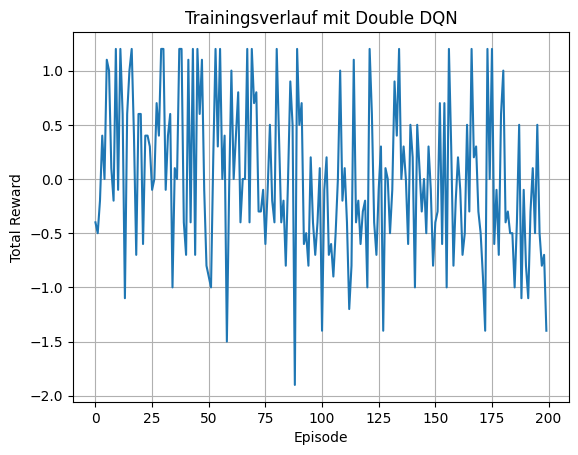

In [23]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Trainingsverlauf mit Double DQN")
plt.grid(True)
plt.show()

### Rückkehr zur stabileren Basis: Target Network DQN

Da der Double-DQN-Ansatz in dieser Umgebung keine Verbesserung gebracht hat, wird im Folgenden wieder auf das stabilere Modell mit Target Network zurückgegriffen. Dieses zeigte in früheren Läufen eine gleichmäßigere Entwicklung und reproduzierbare positive Rewards. Um das Potenzial weiter auszuschöpfen, sollen nun durch Feintuning der Hyperparameter (z. B. Episodenzahl, Netzwerkgröße, Lernrate) bessere Ergebnisse erzielt werden.

In [24]:
epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay = 750  # langsameres Ausexplorieren
num_episodes = 500   # mehr Trainingszeit
batch_size = 64      # mehr Stabilität
gamma = 0.99
learning_rate = 0.00025

class DQN(nn.Module):
    def __init__(self, input_dim=8, output_dim=2):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.out = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)


model = DQN()
target_model = DQN()
target_model.load_state_dict(model.state_dict())
target_model.eval()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

rewards = []
epsilon = epsilon_start

for episode in range(num_episodes):
    env.reset_game()
    state = np.array(list(env.getGameState().values()), dtype=np.float32)
    total_reward = 0

    while not env.game_over():
        # ε-greedy Action Selection
        if np.random.rand() < epsilon:
            action = random.choice(actions)
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            q_values = model(state_tensor)
            action_index = torch.argmax(q_values).item()
            action = actions[action_index]

        reward = env.act(action)
        reward += 0.1  

        next_state = np.array(list(env.getGameState().values()), dtype=np.float32)
        done = env.game_over()

        buffer.push(state, actions.index(action), reward, next_state, done)

        # DQN-Training mit Target Network
        loss = train_dqn(model, target_model, buffer, optimizer, batch_size, gamma)

        state = next_state
        total_reward += reward

    # Target-Network aktualisieren
    if episode % 10 == 0:
        target_model.load_state_dict(model.state_dict())

    # ε reduzieren
    epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-episode / epsilon_decay)

    rewards.append(total_reward)
    print(f"Episode {episode+1}: Total Reward = {total_reward:.2f}, Epsilon = {epsilon:.3f}")


Episode 1: Total Reward = 1.20, Epsilon = 1.000
Episode 2: Total Reward = 0.50, Epsilon = 0.999
Episode 3: Total Reward = 0.30, Epsilon = 0.997
Episode 4: Total Reward = -0.90, Epsilon = 0.996
Episode 5: Total Reward = 1.20, Epsilon = 0.995
Episode 6: Total Reward = 1.20, Epsilon = 0.994
Episode 7: Total Reward = -0.20, Epsilon = 0.992
Episode 8: Total Reward = 1.20, Epsilon = 0.991
Episode 9: Total Reward = 1.20, Epsilon = 0.990
Episode 10: Total Reward = 0.20, Epsilon = 0.989
Episode 11: Total Reward = 0.90, Epsilon = 0.987
Episode 12: Total Reward = 1.20, Epsilon = 0.986
Episode 13: Total Reward = 0.30, Epsilon = 0.985
Episode 14: Total Reward = -0.40, Epsilon = 0.984
Episode 15: Total Reward = 1.20, Epsilon = 0.982
Episode 16: Total Reward = 1.20, Epsilon = 0.981
Episode 17: Total Reward = -0.10, Epsilon = 0.980
Episode 18: Total Reward = -0.00, Epsilon = 0.979
Episode 19: Total Reward = 1.40, Epsilon = 0.977
Episode 20: Total Reward = -0.20, Epsilon = 0.976
Episode 21: Total Rewar

### Trainingsverlauf mit Target Network und Hyperparametertuning

Die Abbildung zeigt den Trainingsverlauf eines DQN-Agenten mit Target Network und angepassten Hyperparametern über 500 Episoden. Im Vergleich zu früheren Konfigurationen ist ein stabilerer Lernverlauf erkennbar, wobei sich die Total Rewards in weiten Teilen des Trainings oberhalb von null bewegen. Einzelne Ausreißer mit höheren Rewards treten unregelmäßig auf, während starke Leistungseinbrüche seltener sind. Die Anpassung von Batch Size, Netzwerkarchitektur, Lernrate und Explorationsstrategie trägt damit zu einer insgesamt robusteren Lernentwicklung bei, auch wenn das Verhalten des Agenten weiterhin variiert und keine durchgängig stabile Policy erkennbar ist.

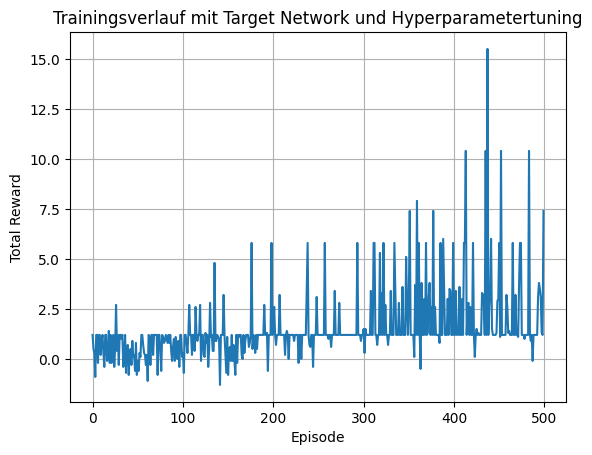

In [25]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Trainingsverlauf mit Target Network und Hyperparametertuning")
plt.grid(True)
plt.show()

### Speichern und Laden des trainierten Agenten

Nach dem Training kann das Modell über `torch.save` gespeichert und später wieder geladen werden. Dies ermöglicht eine einfache Wiederverwendung, z. B. zur Evaluation oder zum Einsatz des Agenten ohne erneutes Training.


In [26]:
torch.save(model.state_dict(), "trained_dqn.pt")

loaded_model = DQN()
loaded_model.load_state_dict(torch.load("trained_dqn.pt"))
loaded_model.eval()


DQN(
  (fc1): Linear(in_features=8, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=2, bias=True)
)

In [27]:
# Agent spielt 5 Episoden mit dem geladenen Modell
num_eval_episodes = 5

for episode in range(num_eval_episodes):
    env.reset_game()
    state = np.array(list(env.getGameState().values()), dtype=np.float32)
    total_reward = 0

    print(f"\n▶️ Episode {episode+1}")

    while not env.game_over():
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        q_values = loaded_model(state_tensor)
        action_index = torch.argmax(q_values).item()
        action = actions[action_index]

        reward = env.act(action)
        next_state = np.array(list(env.getGameState().values()), dtype=np.float32)
        state = next_state
        total_reward += reward

        time.sleep(0.02) 

    print(f"✅ Total Reward: {total_reward:.2f}")



▶️ Episode 1
✅ Total Reward: -5.00

▶️ Episode 2
✅ Total Reward: -5.00

▶️ Episode 3
✅ Total Reward: -5.00

▶️ Episode 4
✅ Total Reward: -5.00

▶️ Episode 5
✅ Total Reward: -5.00


### Beobachtungen zur Evaluation

Im Trainingsverlauf zeigt sich eine moderate Stabilisierung der Agentenleistung. Die Total Rewards bewegen sich in weiten Teilen über null, wobei starke Schwankungen seltener auftreten als in früheren Konfigurationen. Dies deutet auf einen gewissen Lerneffekt hin, auch wenn keine durchgängig robuste Policy erkennbar ist. In der Testphase bleibt das Verhalten inkonsistent: Der Agent kann vereinzelte Hindernisse erfolgreich überwinden, zeigt jedoch keine zuverlässig generalisierbare Strategie. Die Ergebnisse spiegeln damit sowohl die Fortschritte durch Hyperparametertuning als auch die bestehenden Grenzen der DQN-Architektur in dynamischen und stark bestrafenden Umgebungen wie Flappy Bird wider. Eine vertiefte Analyse erfolgt im Projektbericht.


### Vergleich mehrerer Trainingsläufe

Da sich beim wiederholten Ausführen des Notebooks deutlich unterschiedliche Trainingsergebnisse zeigten, wurde die Trainingsroutine nochmals leicht angepasst, um gezielt die Varianz im Lernverlauf sichtbar zu machen. Hierfür wurde die bisherige Trainingslogik in eine Funktion `train_dqn_with_target()` überführt, die zusätzlich einen variablen Seed als Eingabeparameter erhält. So konnte bei identischem Modellaufbau und gleichen Hyperparametern untersucht werden, wie sich unterschiedliche Initialisierungen auf den Verlauf der Total Rewards auswirken.

Die Funktion enthält keinerlei methodische Änderungen gegenüber dem zuvor verwendeten Ansatz (DQN mit Target Network und getuntem Lernverhalten), sondern dient ausschließlich der Strukturierung und Wiederverwendbarkeit. Die Ergebnisse mehrerer solcher Läufe werden im Anschluss gemeinsam visualisiert.


In [28]:
def train_dqn_with_target(seed, env, actions, buffer_fn):
    import torch
    import numpy as np
    import random

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    epsilon_start = 1.0
    epsilon_end = 0.05
    epsilon_decay = 750
    num_episodes = 500
    batch_size = 64
    gamma = 0.99
    learning_rate = 0.00025

    model = DQN()
    target_model = DQN()
    target_model.load_state_dict(model.state_dict())
    target_model.eval()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    buffer = buffer_fn()
    rewards = []
    epsilon = epsilon_start

    for episode in range(num_episodes):
        env.reset_game()
        state = np.array(list(env.getGameState().values()), dtype=np.float32)
        total_reward = 0

        while not env.game_over():
            if np.random.rand() < epsilon:
                action = random.choice(actions)
            else:
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                q_values = model(state_tensor)
                action_index = torch.argmax(q_values).item()
                action = actions[action_index]

            reward = env.act(action)
            reward += 0.1
            next_state = np.array(list(env.getGameState().values()), dtype=np.float32)
            done = env.game_over()

            buffer.push(state, actions.index(action), reward, next_state, done)

            loss = train_dqn(model, target_model, buffer, optimizer, batch_size, gamma)
            state = next_state
            total_reward += reward

        if episode % 10 == 0:
            target_model.load_state_dict(model.state_dict())

        epsilon = epsilon_end + (epsilon_start - epsilon_end) * np.exp(-episode / epsilon_decay)
        rewards.append(total_reward)

    return rewards, model


In [29]:
rewards1, model1 = train_dqn_with_target(42, env, actions, lambda: ReplayBuffer())
rewards2, model2 = train_dqn_with_target(123, env, actions, lambda: ReplayBuffer())
rewards3, model3 = train_dqn_with_target(777, env, actions, lambda: ReplayBuffer())

### Visualisierung der Trainingsverläufe bei unterschiedlicher Initialisierung

Die Abbildung zeigt den Vergleich dreier Trainingsläufe mit identischer Modellkonfiguration, aber unterschiedlichen Seeds. Trotz gleichem Aufbau unterscheiden sich die Lernverläufe, denn während in einem Durchlauf geglättete Total Rewards von über 1.5 erreicht werden, verbleiben andere Runs deutlich darunter.

Diese Abweichungen unterstreichen die hohe Varianz, die beim Training in der Flappy-Bird-Umgebung auftreten kann. In Plot des vorherigen Trainings (Target Network mit Hyperparametertuning) zeigt der Lauf sogar Rewards von über 10 bis hin zu einem Maximalwert von 15, was sich in den hier dokumentierten Wiederholungen jedoch nicht reproduzieren ließ. Die Grafik verdeutlicht somit, wie sensibel die Lernentwicklung auf zufällige Faktoren wie Netzwerk-Initialisierung oder Startzustände reagiert, selbst bei identischen Trainingsparametern.


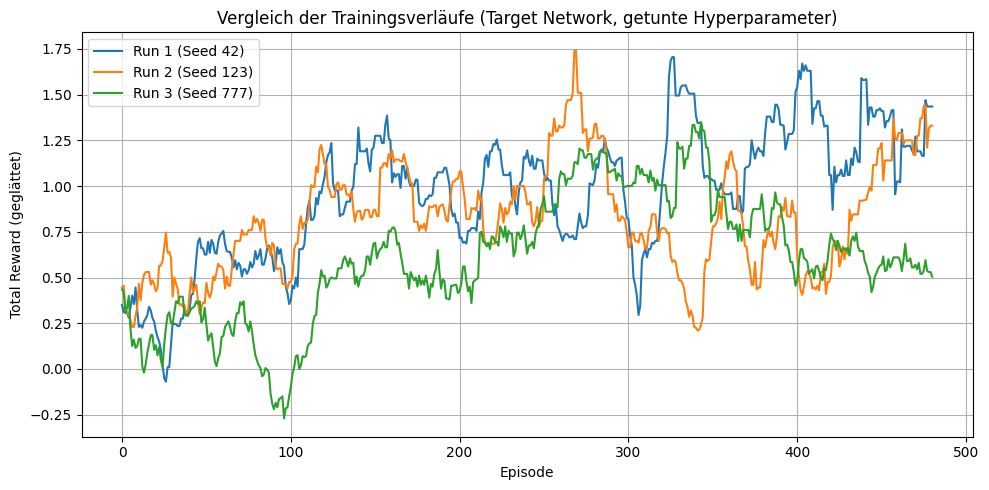

In [30]:
def smooth(data, window=20):
    return np.convolve(data, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(smooth(rewards1), label="Run 1 (Seed 42)")
plt.plot(smooth(rewards2), label="Run 2 (Seed 123)")
plt.plot(smooth(rewards3), label="Run 3 (Seed 777)")
plt.title("Vergleich der Trainingsverläufe (Target Network, getunte Hyperparameter)")
plt.xlabel("Episode")
plt.ylabel("Total Reward (geglättet)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Testepisode ohne Exploration (greedy Policy)

Zum Abschluss wurde das Modell aus dem dritten Trainingslauf (Seed 777) in einer einzelnen Testepisode ohne Exploration getestet. Dabei wurden ausschließlich die Aktionen mit dem höchsten vorhergesagten Q-Wert gewählt, d. h. es kamen keine zufälligen Entscheidungen mehr zum Einsatz. Ziel war es, das Verhalten des Agenten unter stabilen Bedingungen zu beobachten, vergleichbar mit einer realen Anwendungssituation, in der das Modell deterministisch handelt.

In der Testepisode überlebte der Agent **62 Schritte** und erzielte einen **Total Reward von 1.20**. Das Verhalten wirkte dabei kontrollierter als in frühen Trainingsphasen, blieb jedoch instabil und nicht robust gegenüber kleineren Abweichungen. Aufgrund der im Training beobachteten Varianz ist dieses Ergebnis nur als exemplarischer Eindruck zu verstehen und sollte bei weiterführenden Arbeiten durch zusätzliche, aggregierte Testläufe ergänzt werden.



In [31]:
def run_test_episode(env, model, actions):
    import torch
    import numpy as np

    model.eval()
    env.reset_game()
    state = np.array(list(env.getGameState().values()), dtype=np.float32)
    total_reward = 0
    steps = 0

    while not env.game_over():
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q_values = model(state_tensor)
            action_index = torch.argmax(q_values).item()
        action = actions[action_index]

        reward = env.act(action)
        reward += 0.1
        next_state = np.array(list(env.getGameState().values()), dtype=np.float32)
        state = next_state
        total_reward += reward
        steps += 1

    print(f"Testepisode abgeschlossen: {steps} Schritte, Gesamt-Reward: {total_reward:.2f}")

In [32]:
run_test_episode(env, model3, actions)  

Testepisode abgeschlossen: 62 Schritte, Gesamt-Reward: 1.20
